## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare Data

### Tokenize and Create Padded Sequences

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# Specify Size of Vocabulary
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size)  
tokenizer.fit_on_texts(train_df['News Text'])  

In [7]:
print (len(tokenizer.word_index))

54970


In [8]:
train_sequences = tokenizer.texts_to_sequences(train_df['News Text'])
val_sequences = tokenizer.texts_to_sequences(val_df['News Text'])
test_sequences = tokenizer.texts_to_sequences(test_df['News Text'])

In [9]:
# specify max size of document
max_length = 100
# pad sequences
train_x = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_x = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_x = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [10]:
train_x.shape

(6000, 100)

In [11]:
val_x.shape

(1000, 100)

In [12]:
test_x.shape

(1000, 100)

### Get Label Data

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.fit_transform(val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [15]:
print(f'train_y shape: {train_y.shape}')
print(f'val_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
val_y shape: (1000,)
test_y shape: (1000,)


# Model Training

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU

### Function to Plot Losses

In [17]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [18]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

### Add dropout, both for the input layer and for the recurrent connections within an LSTM layer

In [32]:
# create model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 32))
model_1.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
model_1.add(Dense(4, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [33]:
history_1 = model_1.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - acc: 0.4599 - loss: 1.2043 - val_acc: 0.6680 - val_loss: 0.7898
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.6487 - loss: 0.8503 - val_acc: 0.7540 - val_loss: 0.6352
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.7225 - loss: 0.7180 - val_acc: 0.8050 - val_loss: 0.5542
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.8086 - loss: 0.5777 - val_acc: 0.9020 - val_loss: 0.3864
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.8763 - loss: 0.4250 - val_acc: 0.9100 - val_loss: 0.3521
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.9092 - loss: 0.3327 - val_acc: 0.9210 - val_loss: 0.3206
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.9229 - loss: 0.3003 - val_acc: 0.9290 - val_loss: 0.2924
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.9361 - loss: 0.2501 - val_acc: 0.9270 - val_loss: 0.2953
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

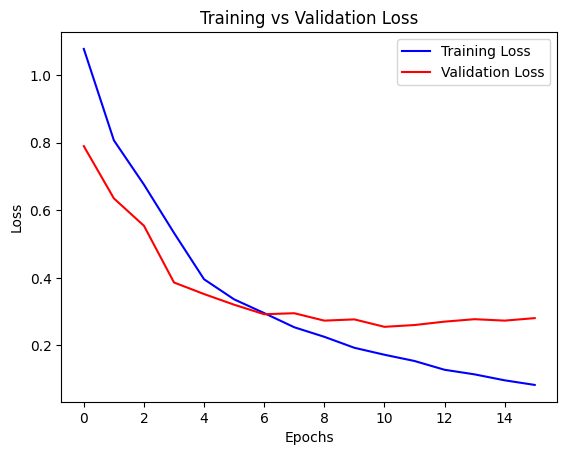

In [34]:
plot_losses(history_1)

### Conclusion: Using Recurrent Dropout, we are able to reach lower validation loss and higher validation accuracy than the best LSTM model (with learned embeddings). Loss decreases from 0.2815 to 0.2551, accuracy goes from 93.6 to 94.2

## Model 2

### Increase Nodes

In [37]:
# create model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 32))
model_2.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(4, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [38]:
history_2 = model_2.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - acc: 0.4377 - loss: 1.1833 - val_acc: 0.6240 - val_loss: 0.8840
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.6521 - loss: 0.8303 - val_acc: 0.7590 - val_loss: 0.6383
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.7706 - loss: 0.6314 - val_acc: 0.8690 - val_loss: 0.4326
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.8828 - loss: 0.4173 - val_acc: 0.9200 - val_loss: 0.3309
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9086 - loss: 0.3422 - val_acc: 0.9110 - val_loss: 0.3166
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9264 - loss: 0.2798 - val_acc: 0.9250 - val_loss: 0.2986
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9316 - loss: 0.2550 - val_acc: 0.9190 - val_loss: 0.2983
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9423 - loss: 0.2173 - val_acc: 0.9230 - val_loss: 0.3108
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

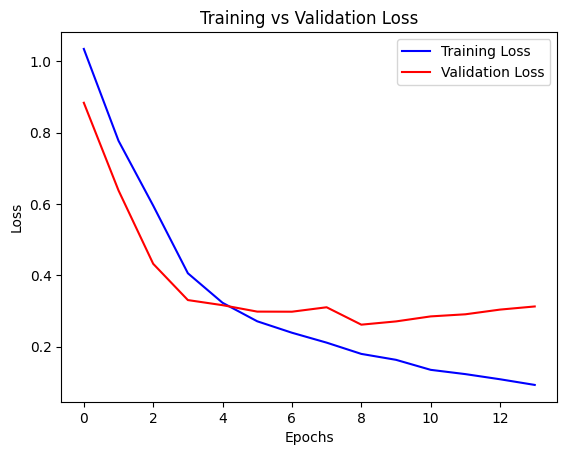

In [39]:
plot_losses(history_2)

### Conclusion: Increasing nodes to 16 reduces performance. However, it is still better than the best model without recurrent dropout

## Model 3

### Change Nodes to 12, from 16

In [40]:
# create model
model_3 = Sequential()
model_3.add(Embedding(vocab_size, 32))
model_3.add(LSTM(12, dropout=0.2, recurrent_dropout=0.2))
model_3.add(Dense(4, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [41]:
history_3 = model_3.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - acc: 0.4154 - loss: 1.2236 - val_acc: 0.8470 - val_loss: 0.6336
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - acc: 0.7995 - loss: 0.6783 - val_acc: 0.8880 - val_loss: 0.4348
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.8509 - loss: 0.5120 - val_acc: 0.9000 - val_loss: 0.3834
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.8916 - loss: 0.3922 - val_acc: 0.9150 - val_loss: 0.3341
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9031 - loss: 0.3671 - val_acc: 0.9200 - val_loss: 0.3258
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9199 - loss: 0.3176 - val_acc: 0.9130 - val_loss: 0.3441
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - acc: 0.9322 - loss: 0.2829 - val_acc: 0.9180 - val_loss: 0.3309
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - acc: 0.9330 - loss: 0.2628 - val_acc: 0.9200 - val_loss: 0.3172
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

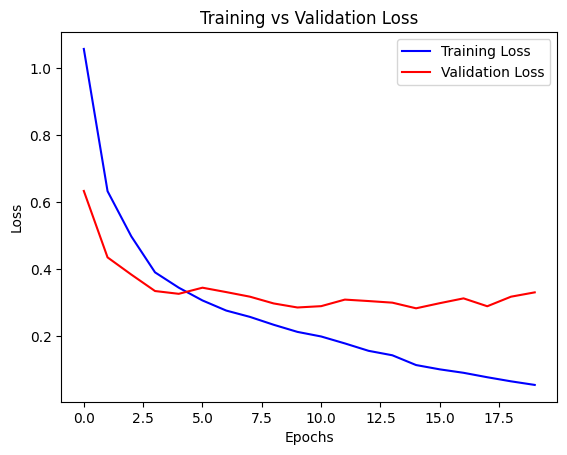

In [42]:
plot_losses(history_3)

### Conclusion: Model performance is worse compared to model with just 8 nodes

## Model 4

### Increase Recurrent Dropout

In [43]:
# create model
model_4 = Sequential()
model_4.add(Embedding(vocab_size, 32))
model_4.add(LSTM(8, dropout=0.2, recurrent_dropout=0.25))
model_4.add(Dense(4, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [44]:
history_4 = model_4.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - acc: 0.3989 - loss: 1.2693 - val_acc: 0.5900 - val_loss: 0.9079
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.5957 - loss: 0.9417 - val_acc: 0.6900 - val_loss: 0.7582
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.6828 - loss: 0.7851 - val_acc: 0.8350 - val_loss: 0.5525
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.7774 - loss: 0.6317 - val_acc: 0.9000 - val_loss: 0.4017
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.8625 - loss: 0.4620 - val_acc: 0.9050 - val_loss: 0.3621
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.8956 - loss: 0.3585 - val_acc: 0.9260 - val_loss: 0.3084
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.9206 - loss: 0.2939 - val_acc: 0.9270 - val_loss: 0.2864
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.9244 - loss: 0.2770 - val_acc: 0.9260 - val_loss: 0.2774
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms

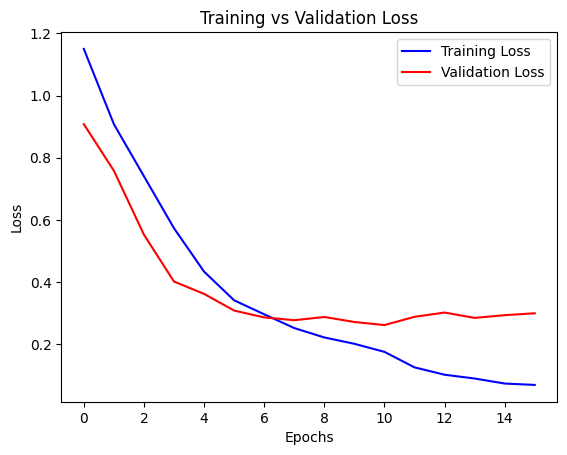

In [45]:
plot_losses(history_4)

### Conclusion: Increasing the value for recurrent dropout impairs performance

# Get Metrics on Test Set

In [46]:
from sklearn.metrics import classification_report, accuracy_score

In [47]:
y_pred = model_1.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0     0.9476    0.9400    0.9438       250
           1     0.9317    0.9280    0.9299       250
           2     0.9368    0.9480    0.9423       250
           3     0.9640    0.9640    0.9640       250

    accuracy                         0.9450      1000
   macro avg     0.9450    0.9450    0.9450      1000
weighted avg     0.9450    0.9450    0.9450      1000

Accuracy: 0.9450
